# Imports

In [76]:
import datetime
import os
import sys
from dataclasses import dataclass
import sklearn
from sklearn import model_selection
import matplotlib
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
from pandas_profiling import ProfileReport
from plotly import express as px
import plotly.graph_objects as go
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# Set the current working directory and get paths of load profiles

In [2]:
def get_directories(path) -> list:
    """
    Returns a list of directories in the given path.
    """
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
directories = get_directories('Profiles')
directories.sort()

# Builds load profile dataframe using all Excel Files
- Dropped last four NA values during cleaning
- Note the overall goal is to predict those four values

In [17]:

directories = get_directories('Profiles')
load_data = pd.DataFrame()
for directory in directories:
    file_name = directory.replace("_", ' ')
    #profile_df = load_profile_df('Profiles/ERCOT_Backcasted_Load_Profiles_2016/ERCOT Backcasted Load Profiles 2016.xls')
    try: 
        profile_df = pd.read_excel(f'Profiles/{directory}/{file_name}.xls', index_col = 0, engine='xlrd')
    except:
        profile_df = pd.read_excel(f'Profiles/{directory}/{file_name}.xlsx', index_col = 0, engine = 'openpyxl')
    #prof = ProfileReport(profile_df, title=file_name, minimal=True)
    load_data = pd.concat([load_data, profile_df])
    #prof.to_file(f'Profiles/{directory}/{file_name}.html')
    #profile_df["Date"] = pd.to_datetime(profile_df["Date"])
save_load_df = load_data.copy()
    #date = profile_df["Date"]
    #profile_df.set_index("Date", inplace=True)
    #print(profile_df.columns)
    #profile_df["PType_WZ"] = profile_df["PType_WZ"].astype(str)
#profile_df.plot()
#plt.savefig(f'Profiles/{directory}/{directory}_plot.png')
#plt.show()
save_load_df.reset_index(inplace=True)

/home/austin/anaconda3/envs/bittensor/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [18]:
if 'PType_WZ' in save_load_df.columns:
    save_load_df.rename(columns={'PType_WZ':'Station'}, inplace=True)

save_load_df.head()

,Station,Date,int_kWh1,int_kWh2,int_kWh3,int_kWh4,int_kWh5,int_kWh6,int_kWh7,int_kWh8,...,int_kWh92,int_kWh93,int_kWh94,int_kWh95,int_kWh96,int_kWh97,int_kWh98,int_kWh99,int_kWh100,ADDTIME
0,BUSHIDG_COAST,2019-01-01,11.406,11.329,11.279,11.236,11.219,11.211,11.174,11.167,...,12.022,11.810,11.708,11.609,11.462,NaN,NaN,NaN,NaN,2019-01-05
1,BUSHIDG_COAST,2019-01-02,11.530,11.461,11.422,11.398,11.407,11.416,11.391,11.405,...,12.062,11.841,11.728,11.623,11.470,NaN,NaN,NaN,NaN,2019-01-06
2,BUSHIDG_COAST,2019-01-03,11.617,11.546,11.505,11.477,11.483,11.489,11.461,11.470,...,11.950,11.748,11.645,11.546,11.399,NaN,NaN,NaN,NaN,2019-01-07
3,BUSHIDG_COAST,2019-01-04,11.374,11.301,11.255,11.220,11.218,11.215,11.179,11.172,...,12.381,12.167,12.067,11.969,11.821,NaN,NaN,NaN,NaN,2019-01-08
4,BUSHIDG_COAST,2019-01-05,11.652,11.568,11.509,11.453,11.409,11.392,11.355,11.354,...,12.338,12.133,12.044,11.952,11.811,NaN,NaN,NaN,NaN,2019-01-09


In [19]:
if "ADDTIME" in save_load_df.columns:
    save_load_df.drop(columns=["ADDTIME"], inplace=True)
id_vars = ['Station', 'Date']

load_columns = save_load_df.columns.tolist()[2:98]
daily_time_intervals = pd.Series(pd.date_range('1/1/2020', '1/2/2020', freq='15min', closed='left')).dt.time # Dummy dates used to get dail time intervals

new_load_columns = {load_columns[i]: daily_time_intervals[i] for i in range(len(load_columns))}

save_load_df.rename(columns=new_load_columns, inplace=True)
load_columns = save_load_df.columns.tolist()[2:98]
all_columns = save_load_df.columns.tolist()[1:99]
#station_list = save_load_df.Station.unique().tolist()



#long_load_data = save_load_df.pivot(index=load_columns, columns='load', values= 'Station')

#pd.melt(long_load_data, id_vars=id_vars, value_name='Load')
dates = save_load_df['Date']
#saved_load_df = save_load_df.groupby(['Station', 'Date'])
save_load_df.head()

,Station,Date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,...,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00,int_kWh97,int_kWh98,int_kWh99,int_kWh100
0,BUSHIDG_COAST,2019-01-01,11.406,11.329,11.279,11.236,11.219,11.211,11.174,11.167,...,12.157,12.022,11.810,11.708,11.609,11.462,NaN,NaN,NaN,NaN
1,BUSHIDG_COAST,2019-01-02,11.530,11.461,11.422,11.398,11.407,11.416,11.391,11.405,...,12.212,12.062,11.841,11.728,11.623,11.470,NaN,NaN,NaN,NaN
2,BUSHIDG_COAST,2019-01-03,11.617,11.546,11.505,11.477,11.483,11.489,11.461,11.470,...,12.090,11.950,11.748,11.645,11.546,11.399,NaN,NaN,NaN,NaN
3,BUSHIDG_COAST,2019-01-04,11.374,11.301,11.255,11.220,11.218,11.215,11.179,11.172,...,12.511,12.381,12.167,12.067,11.969,11.821,NaN,NaN,NaN,NaN
4,BUSHIDG_COAST,2019-01-05,11.652,11.568,11.509,11.453,11.409,11.392,11.355,11.354,...,12.452,12.338,12.133,12.044,11.952,11.811,NaN,NaN,NaN,NaN


In [31]:
sorted_load = save_load_df.sort_values(by=['Station', 'Date']).reset_index(drop=True)
sorted_load.head()

,Station,Date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,...,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00,int_kWh97,int_kWh98,int_kWh99,int_kWh100
0,BUSHIDG_COAST,2016-01-01,11.489,11.413,11.364,11.325,11.312,11.307,11.273,11.273,...,12.015,11.900,11.711,11.624,11.536,11.399,NaN,NaN,NaN,NaN
1,BUSHIDG_COAST,2016-01-02,11.668,11.589,11.538,11.494,11.472,11.464,11.430,11.431,...,12.307,12.199,12.007,11.923,11.836,11.699,NaN,NaN,NaN,NaN
2,BUSHIDG_COAST,2016-01-03,11.457,11.381,11.332,11.291,11.271,11.266,11.235,11.241,...,12.075,11.953,11.746,11.651,11.558,11.416,NaN,NaN,NaN,NaN
3,BUSHIDG_COAST,2016-01-04,11.358,11.280,11.228,11.182,11.162,11.150,11.111,11.100,...,12.145,11.996,11.804,11.699,11.598,11.450,NaN,NaN,NaN,NaN
4,BUSHIDG_COAST,2016-01-05,11.492,11.418,11.373,11.338,11.336,11.334,11.300,11.296,...,12.350,12.210,12.008,11.906,11.806,11.658,NaN,NaN,NaN,NaN


In [24]:
#sorted_load = sorted_load.transpose()

In [25]:
#sorted_load.head()

,0,1,2,3,4,5,6,7,8,9,...,75630,75631,75632,75633,75634,75635,75636,75637,75638,75639
Station,BUSHIDG_COAST,BUSHIDG_COAST,BUSHIDG_COAST,BUSHIDG_COAST,BUSHIDG_COAST,BUSHIDG_COAST,BUSHIDG_COAST,BUSHIDG_COAST,BUSHIDG_COAST,BUSHIDG_COAST,...,RESLOWR_WEST,RESLOWR_WEST,RESLOWR_WEST,RESLOWR_WEST,RESLOWR_WEST,RESLOWR_WEST,RESLOWR_WEST,RESLOWR_WEST,RESLOWR_WEST,RESLOWR_WEST
Date,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,...,2021-01-22 00:00:00,2021-01-23 00:00:00,2021-01-24 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-01-30 00:00:00,2021-01-31 00:00:00
00:00:00,11.489,11.668,11.457,11.358,11.492,11.534,11.293,11.494,11.846,11.485,...,0.158,0.168,0.160,0.165,0.160,0.164,0.176,0.174,0.146,0.187
00:15:00,11.413,11.589,11.381,11.280,11.418,11.466,11.227,11.423,11.760,11.406,...,0.154,0.162,0.155,0.160,0.155,0.160,0.171,0.169,0.141,0.180
00:30:00,11.364,11.538,11.332,11.228,11.373,11.429,11.191,11.382,11.701,11.354,...,0.149,0.155,0.149,0.154,0.150,0.155,0.167,0.164,0.135,0.174


In [ ]:

'''Referenced from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files'''
class LoadDataset(Dataset):
    def __init__(self, df, transform = None, target_transform=None):
        self.sorted_load = sorted_load
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sorted_load)

    def __getitem__(self, idx):
        sample = self.sorted_load.iloc[idx]
        if self.transform:
            sample = self.transform(sample)
        if self.target_transform:
            sample = self.target_transform(sample)
        return sample

# Plots a single day and also prints first 5 rows, shape, columns, and index of the load profile dataframe

In [30]:
if 'int_kWh97' in save_load_df.columns:
    sorted_load = sorted_load.drop(columns=['int_kWh97', 'int_kWh98', 'int_kWh99', 'int_kWh100'])
sorted_load.head()

,Station,Date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
0,BUSHIDG_COAST,2016-01-01,11.489,11.413,11.364,11.325,11.312,11.307,11.273,11.273,...,12.304,12.261,12.177,12.112,12.015,11.900,11.711,11.624,11.536,11.399
1,BUSHIDG_COAST,2016-01-02,11.668,11.589,11.538,11.494,11.472,11.464,11.430,11.431,...,12.539,12.505,12.448,12.396,12.307,12.199,12.007,11.923,11.836,11.699
2,BUSHIDG_COAST,2016-01-03,11.457,11.381,11.332,11.291,11.271,11.266,11.235,11.241,...,12.358,12.314,12.241,12.175,12.075,11.953,11.746,11.651,11.558,11.416
3,BUSHIDG_COAST,2016-01-04,11.358,11.280,11.228,11.182,11.162,11.150,11.111,11.100,...,12.666,12.581,12.395,12.277,12.145,11.996,11.804,11.699,11.598,11.450
4,BUSHIDG_COAST,2016-01-05,11.492,11.418,11.373,11.338,11.336,11.334,11.300,11.296,...,12.781,12.711,12.570,12.472,12.350,12.210,12.008,11.906,11.806,11.658


In [93]:
single_profile = sorted_load.iloc[0].loc[load_columns]
print(single_profile)
Station = str(sorted_load.iloc[0].loc["Station"])
date_value = str(sorted_load.iloc[0].loc["Date"])[:-9]
fig = go.Figure()
fig.add_trace(go.Scatter(x = single_profile.index, y = single_profile.values, name = Station))

fig.update_layout(title = f"Daily Load {date_value} at {Station}", showlegend=True)
fig.update_xaxes(tickangle=45, title_text="Time of Day")
fig.update_yaxes(title_text="Load (kW)")
fig.show()

00:00:00    11.489
00:15:00    11.413
00:30:00    11.364
00:45:00    11.325
01:00:00    11.312
             ...  
22:45:00    11.900
23:00:00    11.711
23:15:00    11.624
23:30:00    11.536
23:45:00    11.399
Name: 0, Length: 96, dtype: object


<AxesSubplot:title={'center':'Moving Average'}>

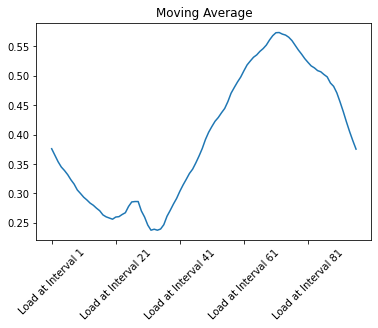

In [ ]:
def moving_average(df, window):
    """
    Calculates the moving average of a given dataframe.
    """
    return df.rolling(window=window).mean()
lp_df = my_load_profiles.copy()
#lp_df = lp_df.T
ma_df = moving_average(lp_df, window=3)

def build_moving_average(df, window):
    """ Build a moving average model."""

#ma_df = ma_df.T
#print(ma_df)
#lp_df['Moving_Avg'] = ma_df
#print(ma_df)
ma_df.iloc[-1].plot(rot=45, title='Moving Average')

# Training, Validation Split

In [ ]:

train_df = my_load_profiles[:int(len(my_load_profiles) * 0.9)]
val_df = my_load_profiles[int(len(my_load_profiles) * 0.9):]
train_df.fillna(0, inplace = True)
val_df.fillna(0, inplace = True)
#print(train_df.isnull().any())
#print(val_df.isnull().any())

def moving_average(df, window):
    """
    Calculates the moving average of a given dataframe.
    """
    return df.rolling(window=window).mean()
vdf = val_df.copy()
#lp_df = lp_df.T
vdma_df = moving_average(vdf, window=3)
#ma_df = ma_df.T
#print(ma_df)
#lp_df['Moving_Avg'] = ma_df



/home/austin/Desktop/Repositories/dae/LFvenv/lib/python3.8/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


# Define and train Neural Network Model

In [ ]:
nn = tf.keras.Sequential([
    tf.keras.layers.Dense(96, input_shape=(96,), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(96, activation='relu'),
])
nn.compile(optimizer='adam', loss='mean_absolute_error')
target_df = train_df.shift(1, axis = 0)
target_df.fillna(0, inplace=True)
#print(target_df)
nn.fit(train_df, target_df, epochs=10)
nn_predictions = nn.predict(val_df)
#nn_predictions = pd.DataFrame(nn_predictions)
#print(nn_predictions)


print(nn.summary())

2021-08-23 19:59:36.971785: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-23 19:59:37.018596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 19:59:37.019025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.74GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-23 19:59:37.019086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-23 19:59:37.019131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

Epoch 1/10
14013/14013 [==============================] - 8s 557us/step - loss: 5.6052
Epoch 2/10
14013/14013 [==============================] - 8s 559us/step - loss: 5.1639
Epoch 3/10
14013/14013 [==============================] - 8s 560us/step - loss: 5.1189
Epoch 4/10
14013/14013 [==============================] - 8s 558us/step - loss: 5.0850
Epoch 5/10
14013/14013 [==============================] - 8s 558us/step - loss: 5.0693
Epoch 6/10
14013/14013 [==============================] - 8s 560us/step - loss: 5.0270
Epoch 7/10
14013/14013 [==============================] - 8s 556us/step - loss: 5.0261
Epoch 8/10
14013/14013 [==============================] - 8s 559us/step - loss: 4.9569
Epoch 9/10
14013/14013 [==============================] - 8s 558us/step - loss: 4.9608
Epoch 10/10
14013/14013 [==============================] - 8s 558us/step - loss: 4.9712
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape  

# Akaike Information Criterion (AIC), out-of-sample error estimate, lower AIC values indicate higher fidelity for out of sample predictions by moving average.
# - Neural Network and Moving Average Baseline

In [ ]:
#print(nn_predictions)
#print(val_df)
nn_predictions = pd.DataFrame(nn_predictions)
#nn_predictions.plot()
nn_mse =  np.mean((nn_predictions - val_df)**2)
moving_average_mse = ((vdma_df-vdf)**2).mean()
print(nn_mse)
print(moving_average_mse)
def aic(mse, k):
    return 2 * k - 2 * mse
aic_nn_mse = aic(nn_mse, k=19058)
aic_vdma_mse = aic(moving_average_mse, k=3)

print("NEURAL NETWORK AIC")
print(aic_nn_mse)
print("MOVING AVERAGE AIC")
print(aic_vdma_mse)


0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
                       ..
Load at Interval 92   NaN
Load at Interval 93   NaN
Load at Interval 94   NaN
Load at Interval 95   NaN
Load at Interval 96   NaN
Length: 192, dtype: float64
Load at Interval 1     46.939683
Load at Interval 2     46.498948
Load at Interval 3     46.065841
Load at Interval 4     45.641024
Load at Interval 5     45.236579
                         ...    
Load at Interval 92    50.972202
Load at Interval 93    77.864314
Load at Interval 94    76.660891
Load at Interval 95    75.504936
Load at Interval 96    74.394733
Length: 96, dtype: float64
NEURAL NETWORK AIC
0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
                       ..
Load at Interval 92   NaN
Load at Interval 93   NaN
Load at Interval 94   NaN
Load at Interval 95   NaN
Load at Interval 

#